<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update10_BTC_Price_Forecasting_with_yfinance_and_FB_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [63]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from prophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the Dataset & Exploring it

In [64]:
 # Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '3y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1086,2023-03-04 00:00:00+00:00,22362.923828,22405.177734,22198.980469,22353.349609,11166012913,0.0,0.0
1087,2023-03-05 00:00:00+00:00,22354.144531,22613.685547,22307.142578,22435.513672,13317001733,0.0,0.0
1088,2023-03-06 00:00:00+00:00,22436.816406,22584.292969,22331.314453,22429.757812,17353192895,0.0,0.0
1089,2023-03-07 00:00:00+00:00,22428.322266,22527.417969,22011.261719,22219.769531,22765452204,0.0,0.0
1090,2023-03-08 00:00:00+00:00,22216.441406,22268.896484,21708.050781,21718.080078,22536575684,0.0,0.0
1091,2023-03-09 00:00:00+00:00,21720.080078,21802.716797,20210.306641,20363.021484,30364664171,0.0,0.0
1092,2023-03-10 00:00:00+00:00,20367.001953,20370.595703,19628.253906,20187.244141,39578257695,0.0,0.0
1093,2023-03-11 00:00:00+00:00,20187.876953,20792.525391,20068.660156,20632.410156,30180288176,0.0,0.0
1094,2023-03-12 00:00:00+00:00,20628.029297,22185.031250,20448.806641,22163.949219,29279035521,0.0,0.0
1095,2023-03-13 00:00:00+00:00,22178.580078,24427.390625,21918.199219,24219.162109,51884584960,0.0,0.0


In [65]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03,1096.0,1096.0
mean,29736.174390,30468.891149,28922.077334,29749.537094,3.603795e+10,0.0,0.0
std,16438.824815,16875.675121,15911.767036,16417.170417,1.913609e+10,0.0,0.0
min,5002.578125,5331.833984,4106.980957,5014.479980,7.714767e+09,0.0,0.0
25%,16694.377441,16879.684570,16525.126465,16714.970215,2.469035e+10,0.0,0.0
50%,23947.176758,24522.214844,23530.840820,23952.585938,3.216233e+10,0.0,0.0
75%,42961.791016,43907.089844,41992.264648,42897.068359,4.262710e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [66]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [67]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [68]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [69]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [70]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [71]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 61, 1)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [72]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df=prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df['ds']=prophet_df['ds'].dt.tz_localize(None)
prophet_df.tail()

,ds,y
1091,2023-03-09,20363.021484
1092,2023-03-10,20187.244141
1093,2023-03-11,20632.410156
1094,2023-03-12,22163.949219
1095,2023-03-13,24219.162109


## Creating Facebook Prophet Model

In [73]:
m=Prophet(daily_seasonality=False)
m.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyemlgn17/yp6hf1st.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyemlgn17/fiqmk2a1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2482', 'data', 'file=/tmp/tmpyemlgn17/yp6hf1st.json', 'init=/tmp/tmpyemlgn17/fiqmk2a1.json', 'output', 'file=/tmp/tmpyemlgn17/prophet_modelxhdt2ch_/prophet_model-20230313154417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:44:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:44:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


##Forecasting

In [74]:
periods = 30
future=m.make_future_dataframe(periods)

In [75]:
forecast=m.predict(future)

In [76]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-13,-8799.363160,-3172.977368,3616.256875,-8799.363160,-8799.363160,9122.368869,9122.368869,9122.368869,-18.458927,-18.458927,-18.458927,9140.827796,9140.827796,9140.827796,0.0,0.0,0.0,323.005708
1,2020-03-14,-8580.575600,-2644.954507,4263.127186,-8580.575600,-8580.575600,9565.339944,9565.339944,9565.339944,4.629372,4.629372,4.629372,9560.710573,9560.710573,9560.710573,0.0,0.0,0.0,984.764344
2,2020-03-15,-8361.788040,-1840.513580,4790.923712,-8361.788040,-8361.788040,9982.333841,9982.333841,9982.333841,-5.707979,-5.707979,-5.707979,9988.041820,9988.041820,9988.041820,0.0,0.0,0.0,1620.545801
3,2020-03-16,-8143.000481,-1091.562322,5593.591614,-8143.000481,-8143.000481,10433.120921,10433.120921,10433.120921,17.042650,17.042650,17.042650,10416.078271,10416.078271,10416.078271,0.0,0.0,0.0,2290.120440
4,2020-03-17,-7924.212921,-604.827892,6179.854917,-7924.212921,-7924.212921,10807.946911,10807.946911,10807.946911,-30.053203,-30.053203,-30.053203,10838.000113,10838.000113,10838.000113,0.0,0.0,0.0,2883.733990
5,2020-03-18,-7705.425361,90.129089,6901.965273,-7705.425361,-7705.425361,11317.981490,11317.981490,11317.981490,70.904390,70.904390,70.904390,11247.077099,11247.077099,11247.077099,0.0,0.0,0.0,3612.556129
6,2020-03-19,-7486.637801,1022.512306,7475.516019,-7486.637801,-7486.637801,11598.474560,11598.474560,11598.474560,-38.356303,-38.356303,-38.356303,11636.830863,11636.830863,11636.830863,0.0,0.0,0.0,4111.836759
7,2020-03-20,-7267.850241,1206.433557,8094.705190,-7267.850241,-7267.850241,11982.730326,11982.730326,11982.730326,-18.458927,-18.458927,-18.458927,12001.189253,12001.189253,12001.189253,0.0,0.0,0.0,4714.880085
8,2020-03-21,-7049.062681,1899.314021,8865.463212,-7049.062681,-7049.062681,12339.258124,12339.258124,12339.258124,4.629372,4.629372,4.629372,12334.628752,12334.628752,12334.628752,0.0,0.0,0.0,5290.195443
9,2020-03-22,-6830.275121,2411.441714,8924.535295,-6830.275121,-6830.275121,12626.593400,12626.593400,12626.593400,-5.707979,-5.707979,-5.707979,12632.301379,12632.301379,12632.301379,0.0,0.0,0.0,5796.318279


In [77]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

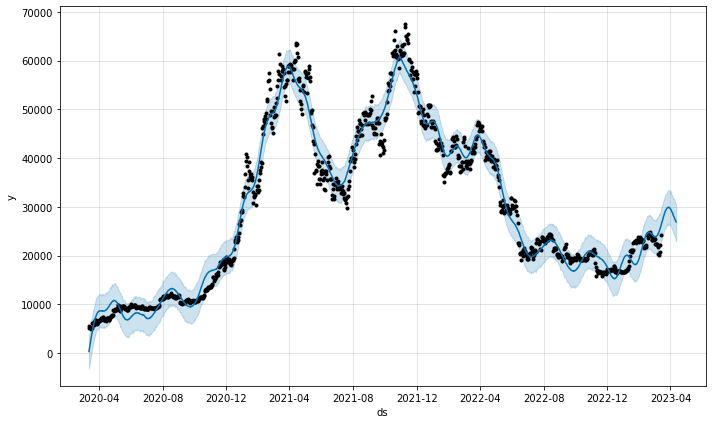

In [78]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

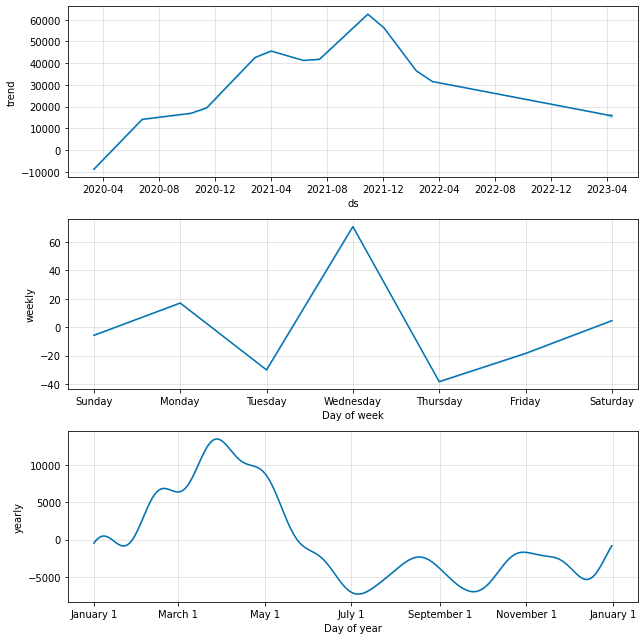

In [79]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [80]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>